In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
train_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
val_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"

In [58]:
trainset = datasets.ImageFolder(train_loc, transform = transforms.Compose(
[transforms.Grayscale(),
transforms.Resize((512,512)),
transforms.ToTensor()]
))

In [59]:
train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle = True)

### Calculation of mean and std

In [75]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in tqdm(loader):
        channels_sum += torch.mean(data, dim = [0,2,3])
        channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

In [76]:
mean, std = get_mean_std(train_loader)

  0%|          | 0/281 [00:00<?, ?it/s]

In [79]:
print(mean, std)

tensor([0.5027]) tensor([0.2466])


### Baseline Solution

In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm.autonotebook import tqdm
import torch
import os

In [2]:
def show_image(image, label, get_denormalized = True):
    
    image = image.permute(1,2,0) #??
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    
    if get_denormalized == True:
        image  = (image*std) + mean
        image  = np.clip(image, 0, 1)
        plt.imshow(image, cmap = 'gray')
        plt.title(label)
        
    else:
        plt.imshow(image, cmap = 'gray')
        plt.title(label)
        
def show_grid(image, title = None): #??
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    image  = (image*std) + mean
    image  = np.clip(image, 0, 1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image, cmap = 'gray')
    if title != None:
        plt.title(title)
        
def accuray(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p, top_class = y_pred.topk(1,dim =1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

def view_classify(image, ps, label):
    class_name = ['covid', 'normal', 'pneumonia']
    classes = np.array(class_name)
    
    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0) #??
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None


    
        

In [3]:
class CFG:
    epochs = 20
    lr = 0.001
    batch_size = 16
    img_size = 224
    
    model_name = 'tf_efficientnet_b4_ns'
    
    train_path = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
    validate_path = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(f"We are on: {device}")
    
    

We are on: cuda


In [5]:
train_set = datasets.ImageFolder(CFG.train_path, transform = T.ToTensor())

In [10]:
(train_set.imgs, train_set.targets)

[('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_1110.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_1111.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_11110.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111100.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111101.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111102.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111103.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111104.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111105.jpg',
  0),
 ('/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/cov_111106.jpg',
  0),
 ('/media/brats

In [17]:
plt.imread(train_set.imgs[9][0]).shape

(1024, 1024, 3)

In [18]:
plt.imread("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/normal/normal-0000.jpg").shape

(1024, 1024)

In [4]:
from torchvision import transforms as T, datasets

In [6]:
train_transform = T.Compose([
#     T.Grayscale(),
    T.Resize(size = (CFG.img_size, CFG.img_size)), 
    T.RandomRotation(degrees = (-20,20)),
    T.ToTensor(),
    T.Normalize([0.5027,0.5027,0.5027], [0.2466,0.2466,0.2466])
]
)

validate_transform = T.Compose([
#     T.Grayscale(),
    T.Resize(size = (CFG.img_size, CFG.img_size)), 
    T.ToTensor(),
    T.Normalize([0.5027,0.5027,0.5027], [0.2466,0.2466,0.2466])
]
)



In [7]:
trainset = datasets.ImageFolder(CFG.train_path, transform = train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  17958


In [8]:
validateset = datasets.ImageFolder(CFG.validate_path, transform = validate_transform)
print("Trainset Size:  {}".format(len(validateset)))

Trainset Size:  3432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


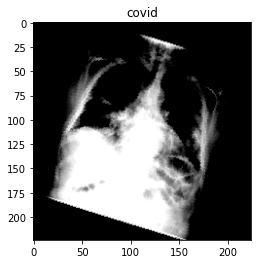

In [9]:
img, label = trainset[20]
show_image(img,trainset.classes[label], get_denormalized=False)

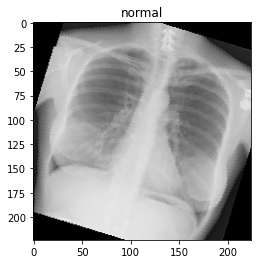

In [10]:
img, label = trainset[8000]
show_image(img,trainset.classes[label], get_denormalized=True)

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size, shuffle = True)
validationloader = DataLoader(validateset, batch_size = CFG.batch_size, shuffle = False)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))
print("No. of batches in validationloader:{}".format(len(validationloader)))
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in trainloader:1123
No. of Total examples:17958
No. of batches in validationloader:215
No. of Total examples:3432


In [13]:
!pip install timm

You should consider upgrading via the '/home/brats/miniconda3/envs/brats/bin/python -m pip install --upgrade pip' command.


In [14]:
from torch import nn
import torch.nn.functional as F
import timm

In [15]:
model = timm.create_model(CFG.model_name, pretrained=True)

In [16]:
for param in model.parameters():
    param.requires_grad=False
    
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features = 768), 
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(in_features = 768, out_features= 256), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=256, out_features=3)

)

In [17]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [18]:
class CovidTrainer():
    def __init__(self, criterion = None, optimizer = None, schedular = None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        
    def train_batch_loop(self, model, trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            
            train_acc += accuray(logits, labels)
            
        return train_loss/len(trainloader), train_acc/len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        
        valid_loss = 0.0
        valid_acc  = 0.0
        
        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            valid_loss += loss.item()
            valid_acc  += accuray(logits, labels)
            
        return valid_loss/len(trainloader), valid_acc/len(trainloader)
    
    
    def fit(self, model, trainloader, validloader, epochs):
        
        valid_min_loss = np.Inf
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'covid_baseline.pt')
                
                valid_min_loss = avg_valid_loss
                
                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
                
                
                
                
            
            
            
            
            
            
            
        
        

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = CovidTrainer(criterion,optimizer)
trainer.fit(model.to(device),trainloader,validationloader,epochs = CFG.epochs)


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.11993773897258915
Epoch : 1 Train Loss : 0.706575 Train Acc : 0.703955
Epoch : 1 Valid Loss : 0.119938 Valid Acc : 0.141641


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.11993773897258915 --> 0.11601524877022763
Epoch : 2 Train Loss : 0.626908 Train Acc : 0.746494
Epoch : 2 Valid Loss : 0.116015 Valid Acc : 0.144256


  0%|          | 0/1123 [00:00<?, ?it/s]

KeyboardInterrupt: 